## **CMPS 460 Group Project L51**
### **Project Members**
Ikram Chebbak 202008509

Shatha Alhazbi 202108114

Tasnim Mushtaha 201906322

Supervisor: Dr. Saeed Salem

### **7. Documentation and Reporting**

Project Summary:
+ Implementing the complete ML pipeline for practical experience.
+ Encouraging creativity in problem-solving and selecting datasets.
+ Promoting understanding through comparing different ML models' performances.

Project Objectives:
+ Using the Mushroom dataset as a source, be able to classify mushrooms as edible or poisonous
+ Know how to interpret the data and links between attributes
+ Be able to clean and pre-process the data into a usable state
+ Use different types of models and fine-tune them to improve their performance

Project Motivations:
+ There are thousands of mushroom species, and people are getting increasingly more daring in their food choices
+ 'Rare' or 'exotic' mushrooms are served in luxurious establishments as fancy food
+ However, to the inexperienced person, the difference between edible and poisonous mushrooms isn't apparent
+ This project aims to create models that can accurately differentiate between edible and poisonous mushrooms based on their physical qualities
+ This would help professionals (scientists, chefs) and casual mushroom foragers alike

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.random import sample_without_replacement
from sklearn.base import clone
from sklearn import metrics
import tensorflow as tf

## **1. Dataset Selection**

In [39]:
# Read the dataset
df = pd.read_csv("https://archive.ics.uci.edu/static/public/848/data.csv")
# The structure of the dataset
print("Dataset dimensions (rows, columns):", df.shape)
print("\nFirst few rows of the dataset:")
print(df.head())

Dataset dimensions (rows, columns): (61069, 21)

First few rows of the dataset:
  class  cap-diameter cap-shape cap-surface cap-color does-bruise-or-bleed  \
0     p         15.26         x           g         o                    f   
1     p         16.60         x           g         o                    f   
2     p         14.07         x           g         o                    f   
3     p         14.17         f           h         e                    f   
4     p         14.64         x           h         o                    f   

  gill-attachment gill-spacing gill-color  stem-height  ...  stem-root  \
0               e          NaN          w        16.95  ...          s   
1               e          NaN          w        17.99  ...          s   
2               e          NaN          w        17.80  ...          s   
3               e          NaN          w        15.77  ...          s   
4               e          NaN          w        16.53  ...          s   

  stem

## **2. Exploratory Data Analysis**

In [3]:
# Summary of the numerical features
print("Summary statistics of numerical features:")
print(df.describe())

# Modes of the categorical features
categoric_df = df.select_dtypes(include='object') # Select only categoric columns
print("\nSummary of the modes of categorical features:")
print("Column\t\t     Mode")
rows = []
for col in categoric_df.columns:
    rows.append([col, categoric_df[col].mode()[0]])
print(pd.DataFrame(rows).to_string(index=False, header=False))

Summary statistics of numerical features:
       cap-diameter   stem-height    stem-width
count  61069.000000  61069.000000  61069.000000
mean       6.733854      6.581538     12.149410
std        5.264845      3.370017     10.035955
min        0.380000      0.000000      0.000000
25%        3.480000      4.640000      5.210000
50%        5.860000      5.950000     10.190000
75%        8.540000      7.740000     16.570000
max       62.340000     33.920000    103.910000

Summary of the modes of categorical features:
Column		     Mode
               class p
           cap-shape x
         cap-surface t
           cap-color n
does-bruise-or-bleed f
     gill-attachment a
        gill-spacing c
          gill-color w
           stem-root b
        stem-surface s
          stem-color w
           veil-type u
          veil-color w
            has-ring f
           ring-type f
   spore-print-color k
             habitat d
              season a


In [4]:
# Number of null values
print("Number of missing values in each column:")
print(df.isnull().sum())

Number of missing values in each column:
class                       0
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-type               57892
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season                      0
dtype: int64


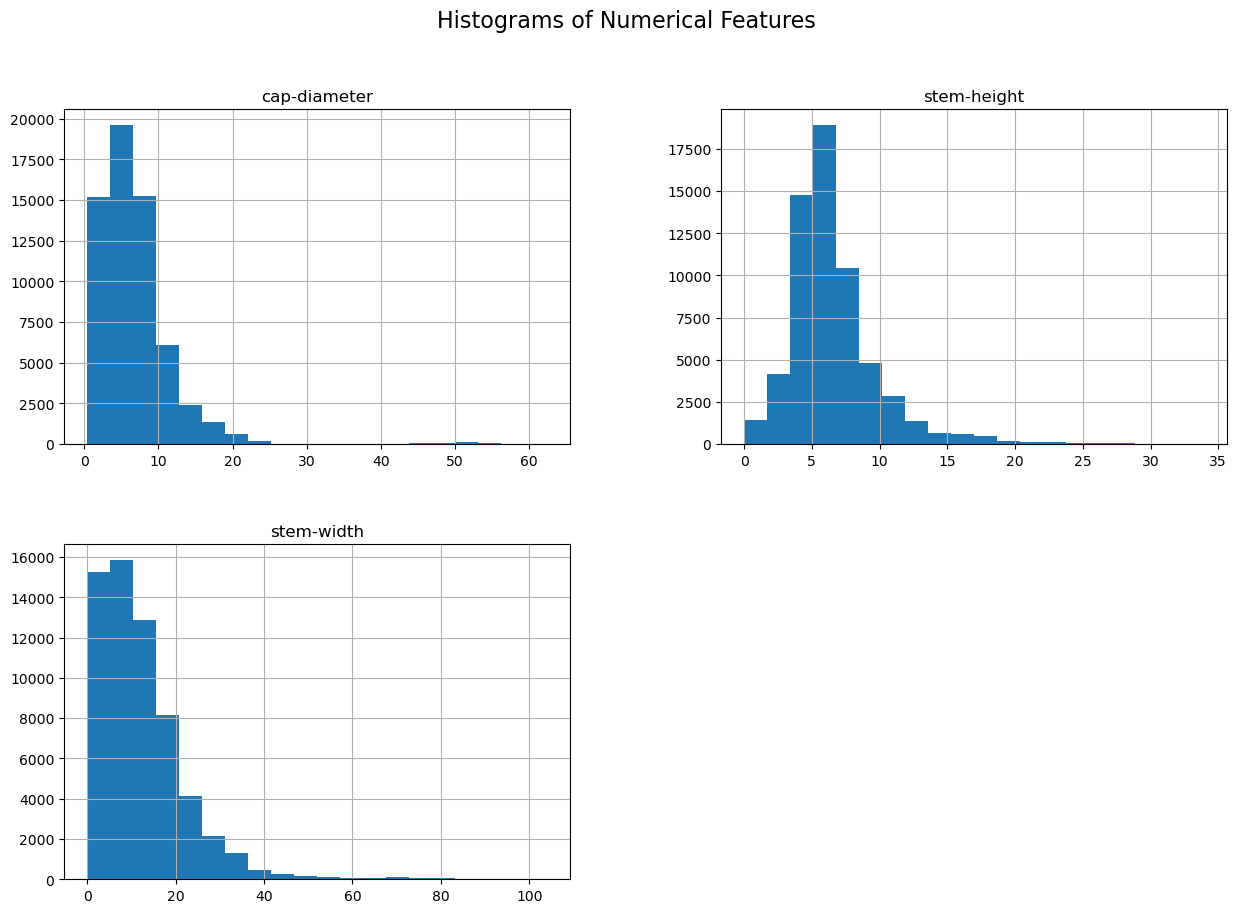

In [5]:
# Histograms for numerical features
df.hist(bins=20, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features', fontsize=16)
plt.show()

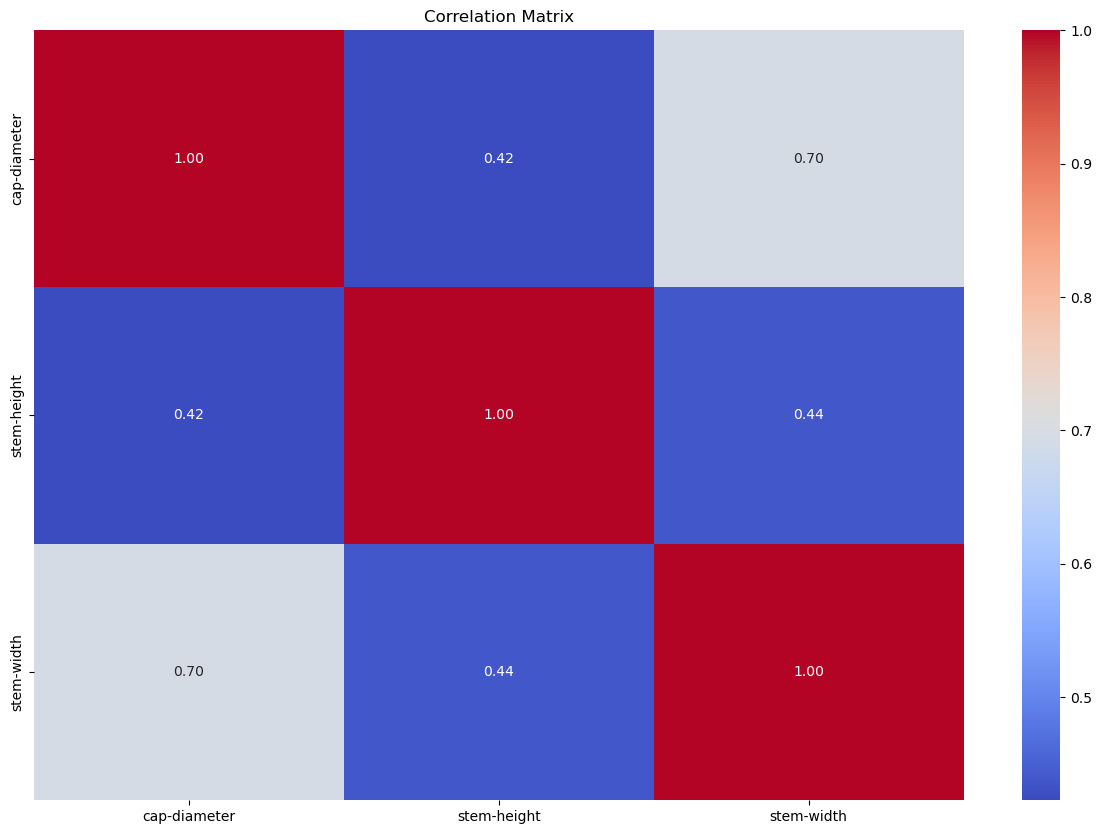

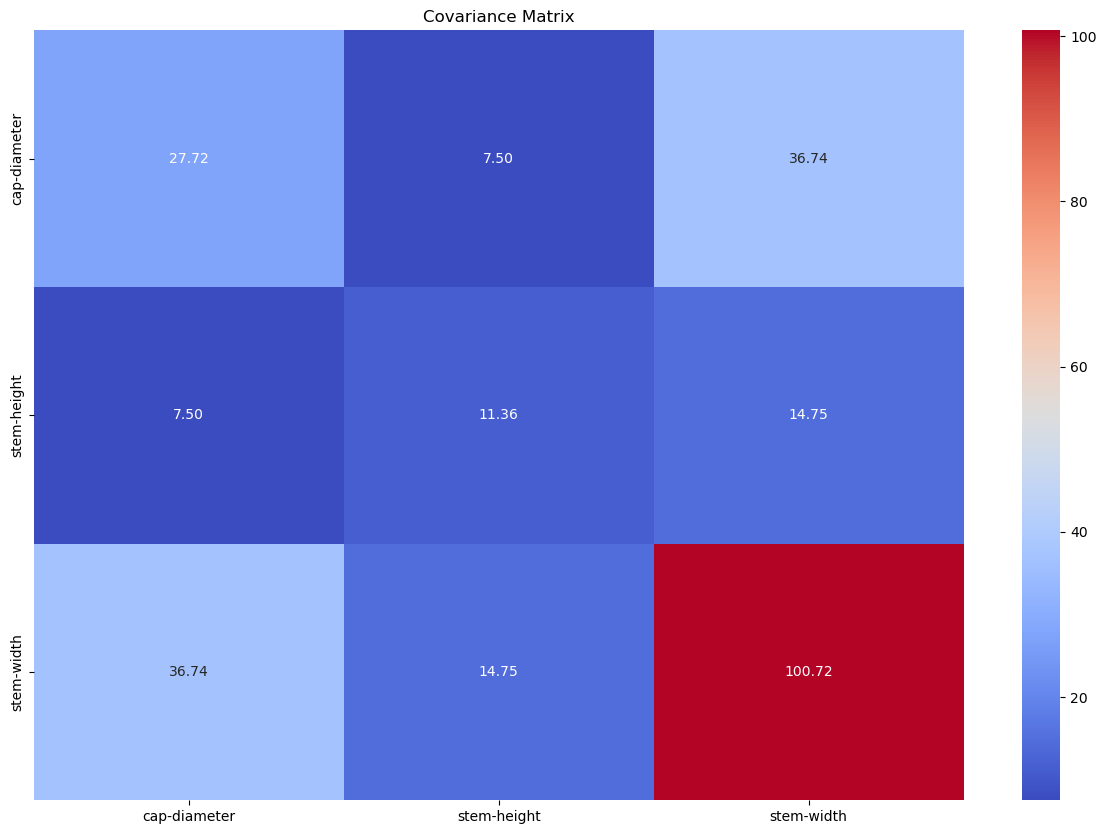

In [6]:
# Correlation analysis
numeric_df = df.select_dtypes(include='number')  # Select only numeric columns
correlation_matrix = numeric_df.corr()  # Compute correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Covariance analysis
covariance_matrix = numeric_df.cov()  # Compute covariance matrix
plt.figure(figsize=(15, 10))
sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Covariance Matrix')
plt.show()

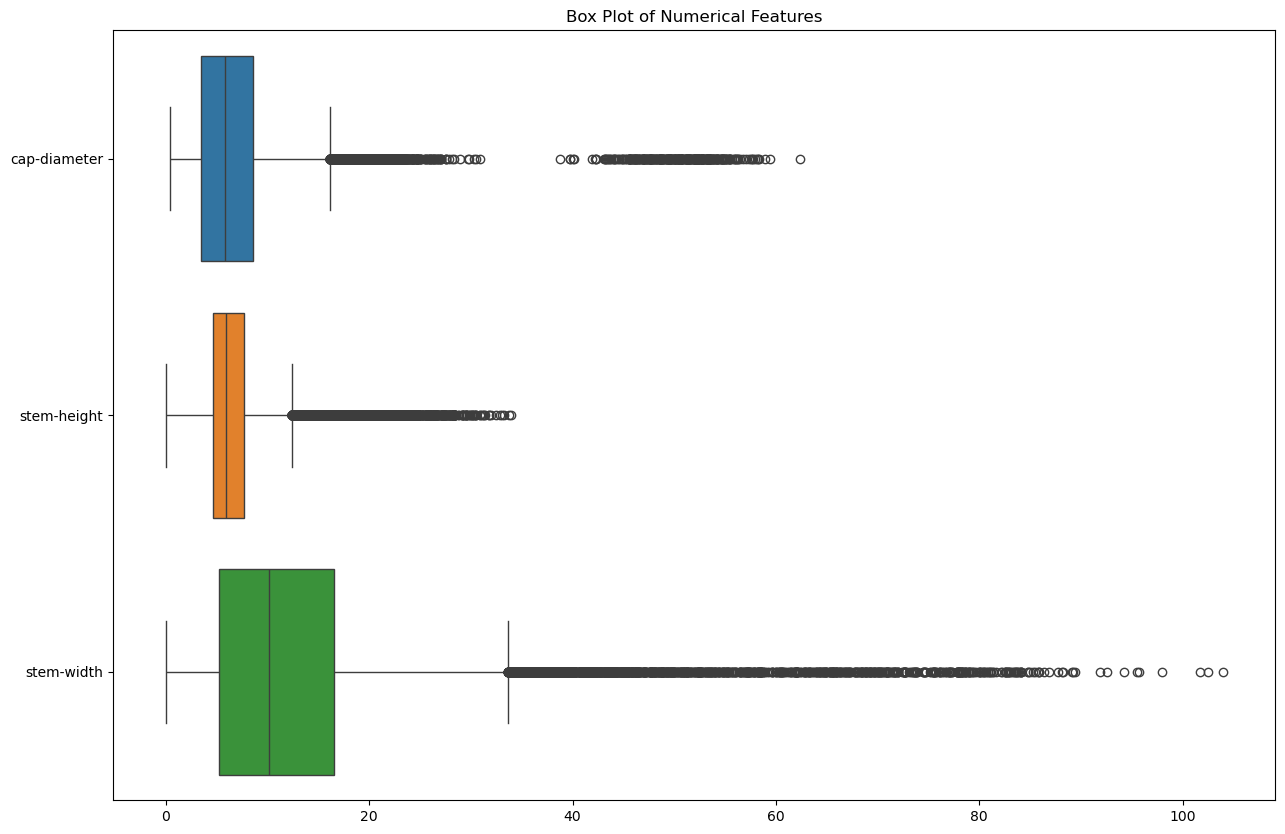

In [7]:
# Box plot of numerical features 
plt.figure(figsize=(15, 10))
sns.boxplot(data=df, orient='h')
plt.title('Box Plot of Numerical Features')
plt.show()

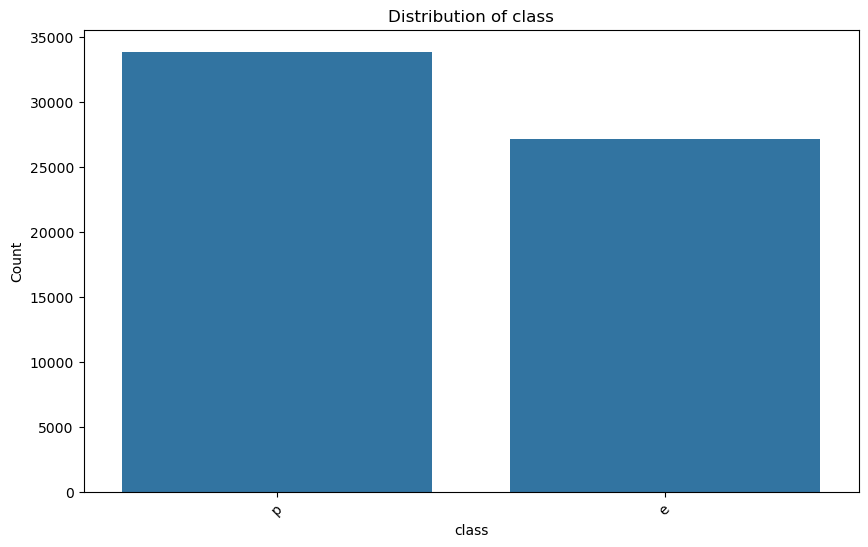

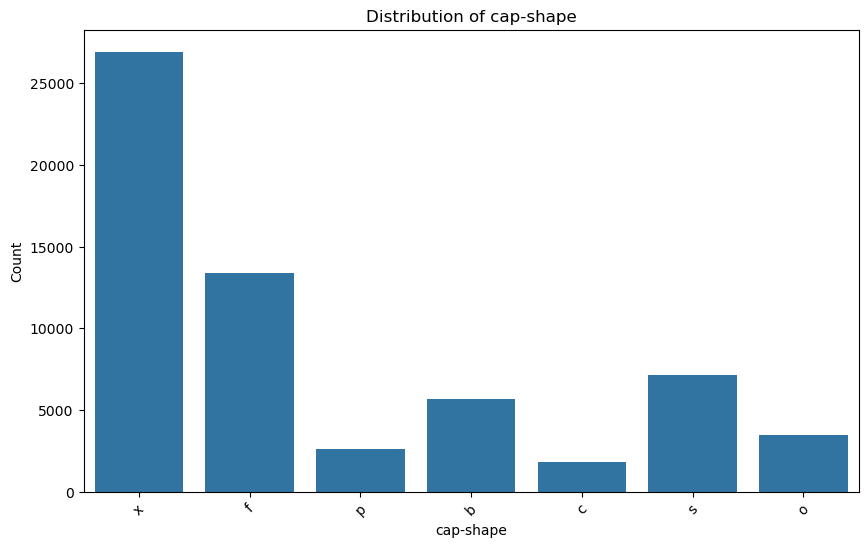

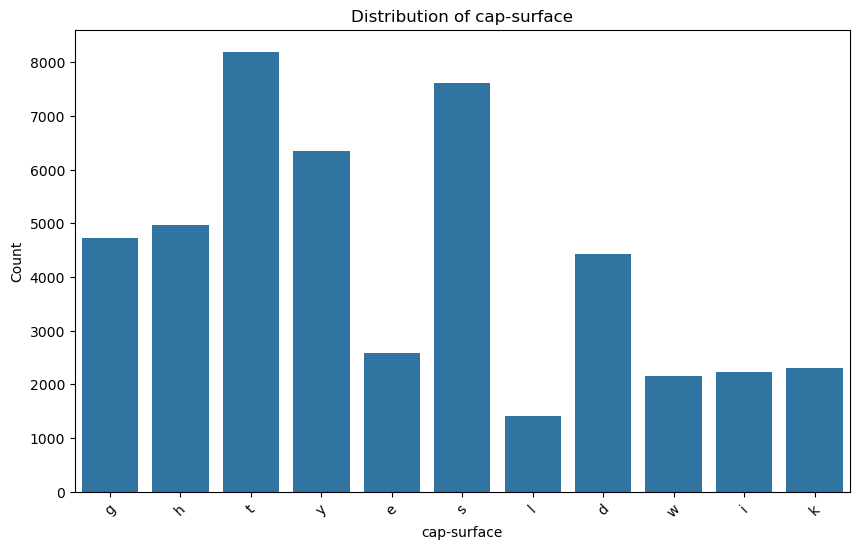

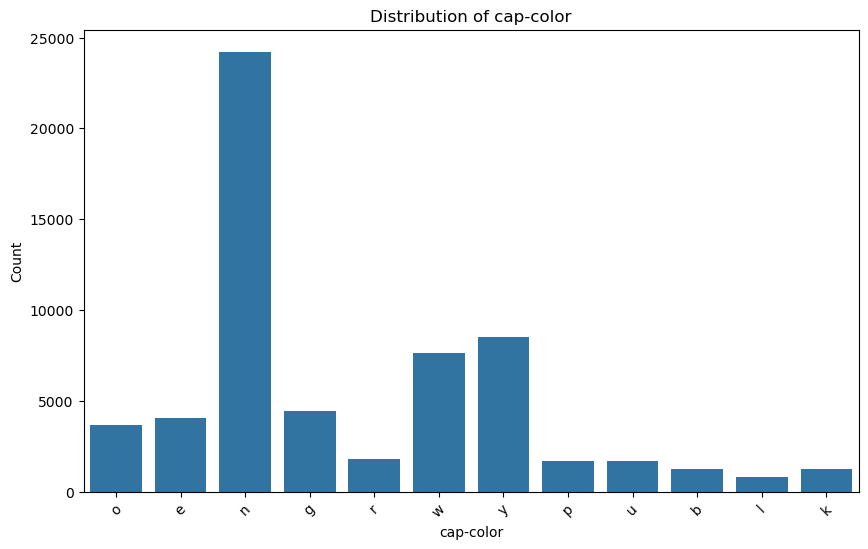

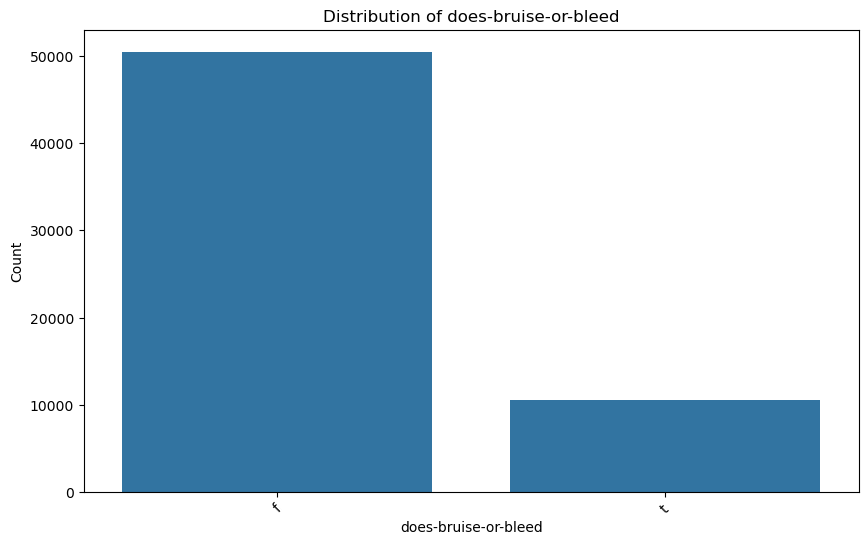

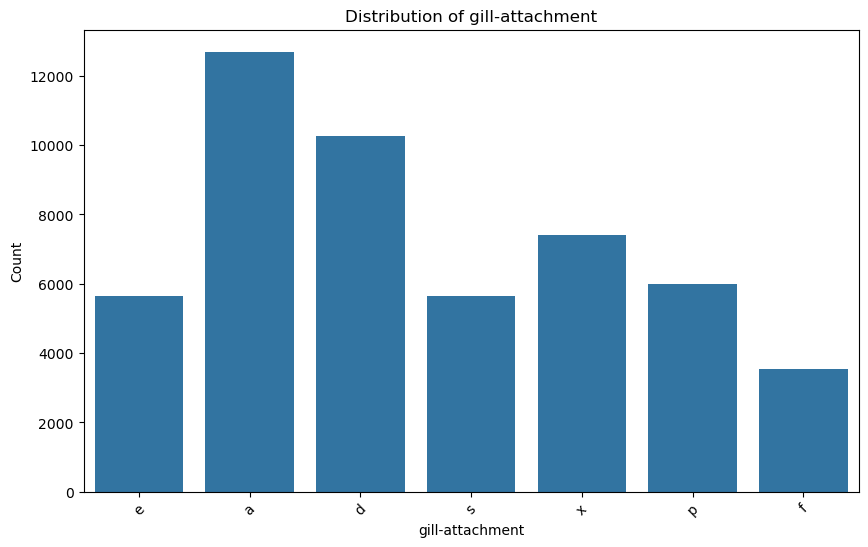

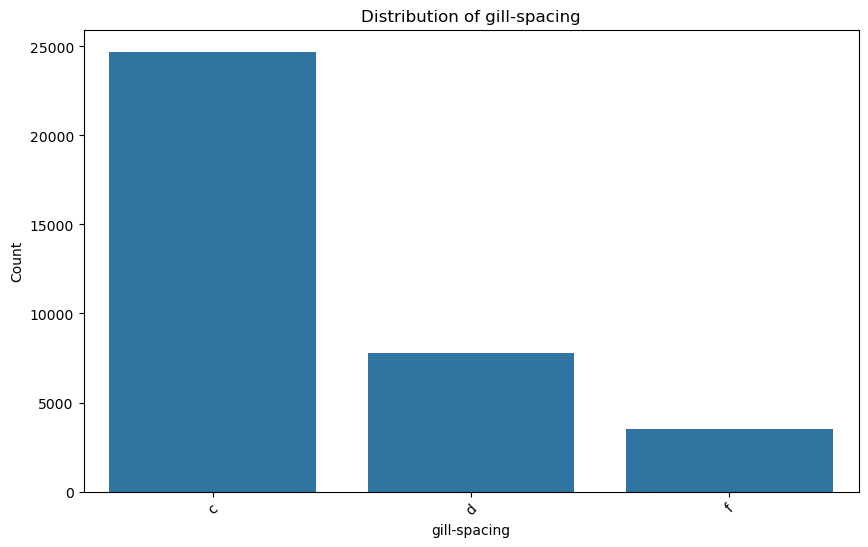

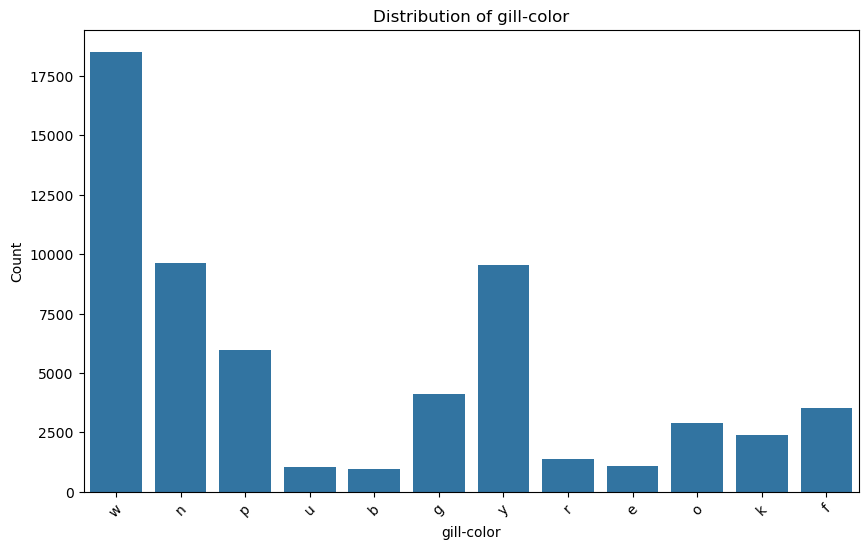

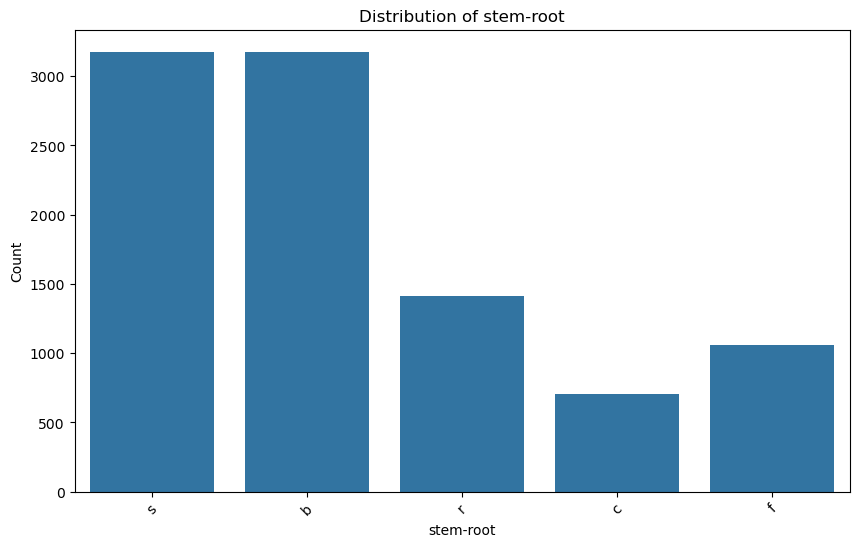

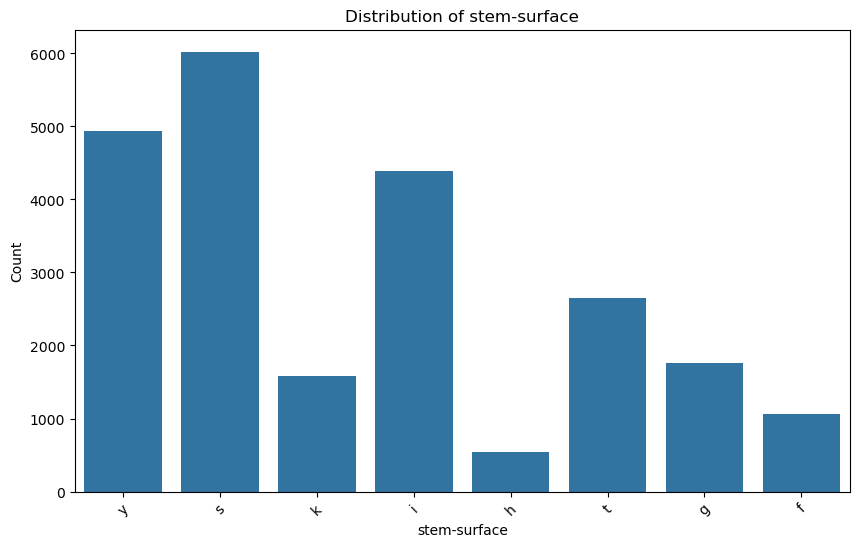

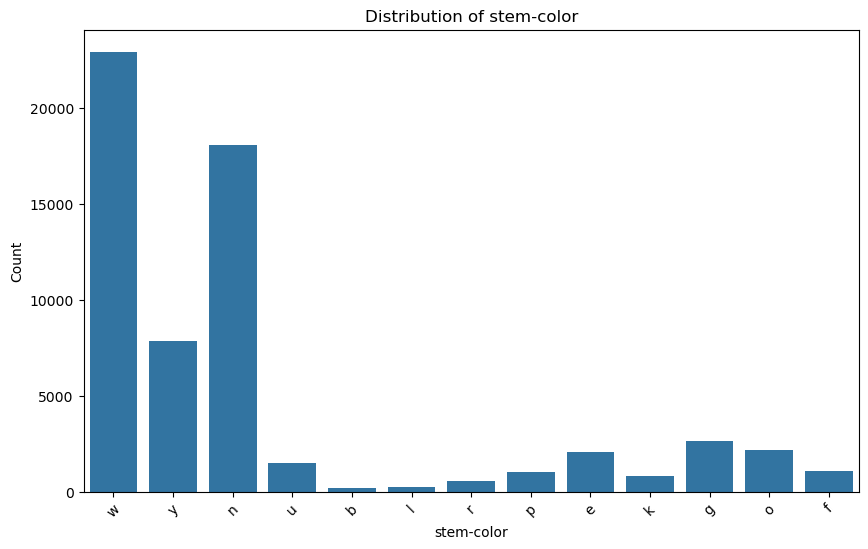

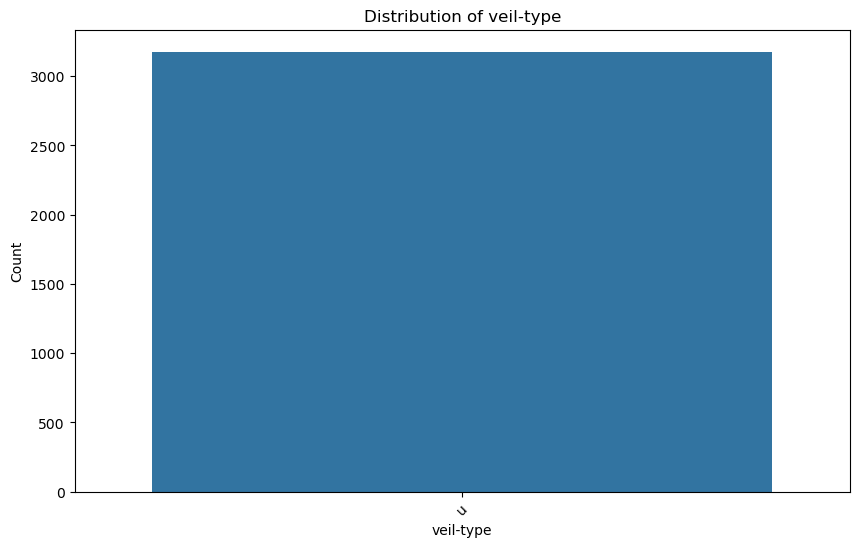

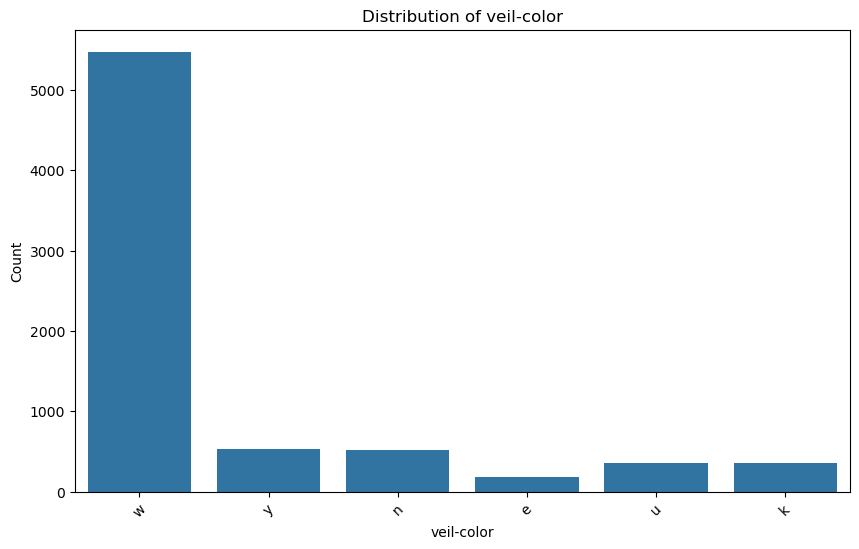

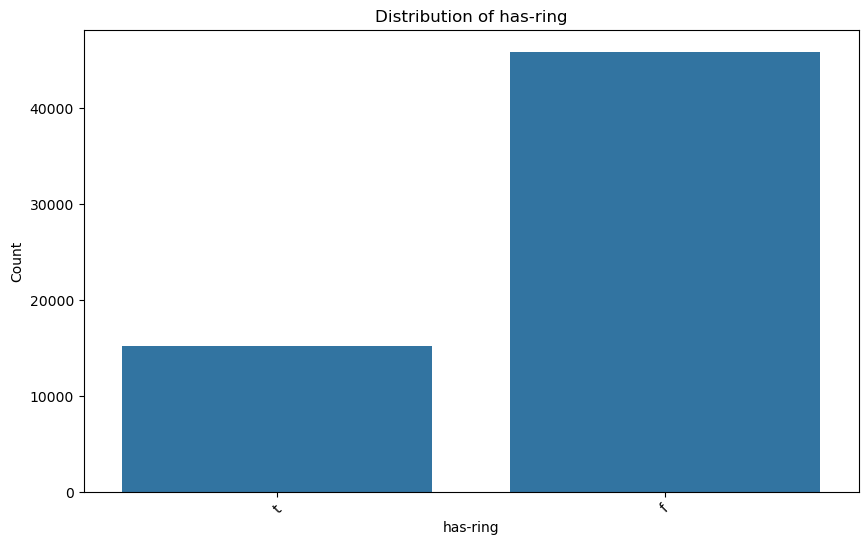

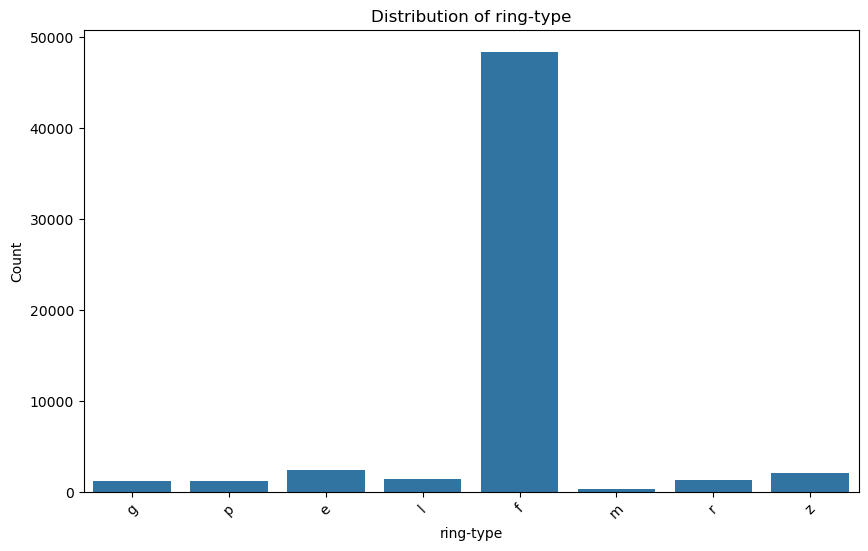

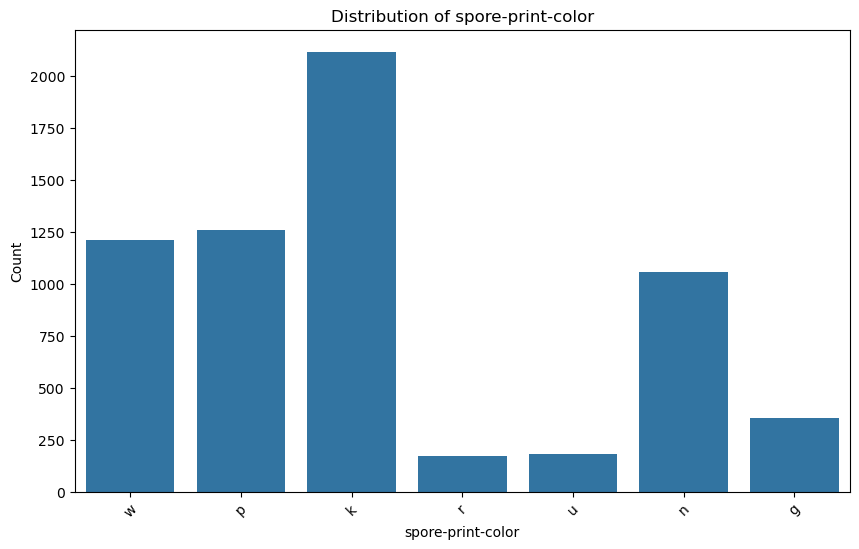

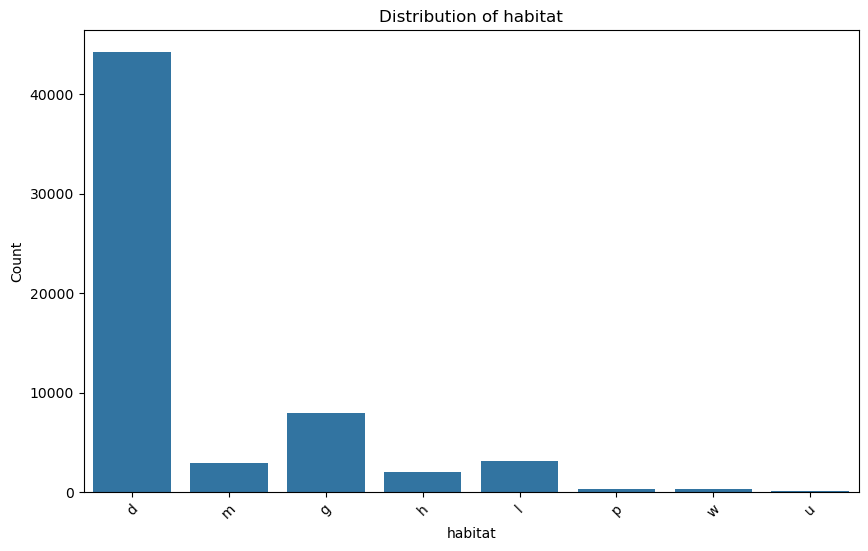

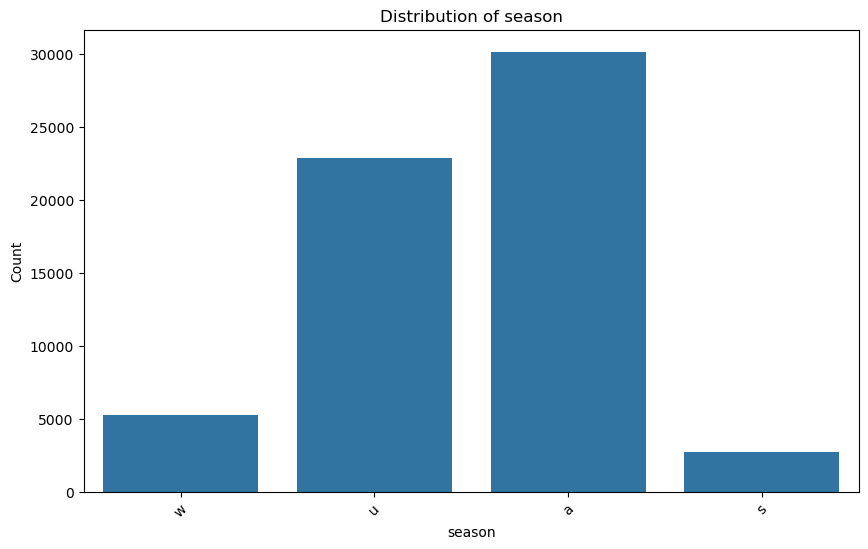

In [8]:
# Distribution of categorical features (if applicable)
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

<Figure size 1500x1200 with 0 Axes>

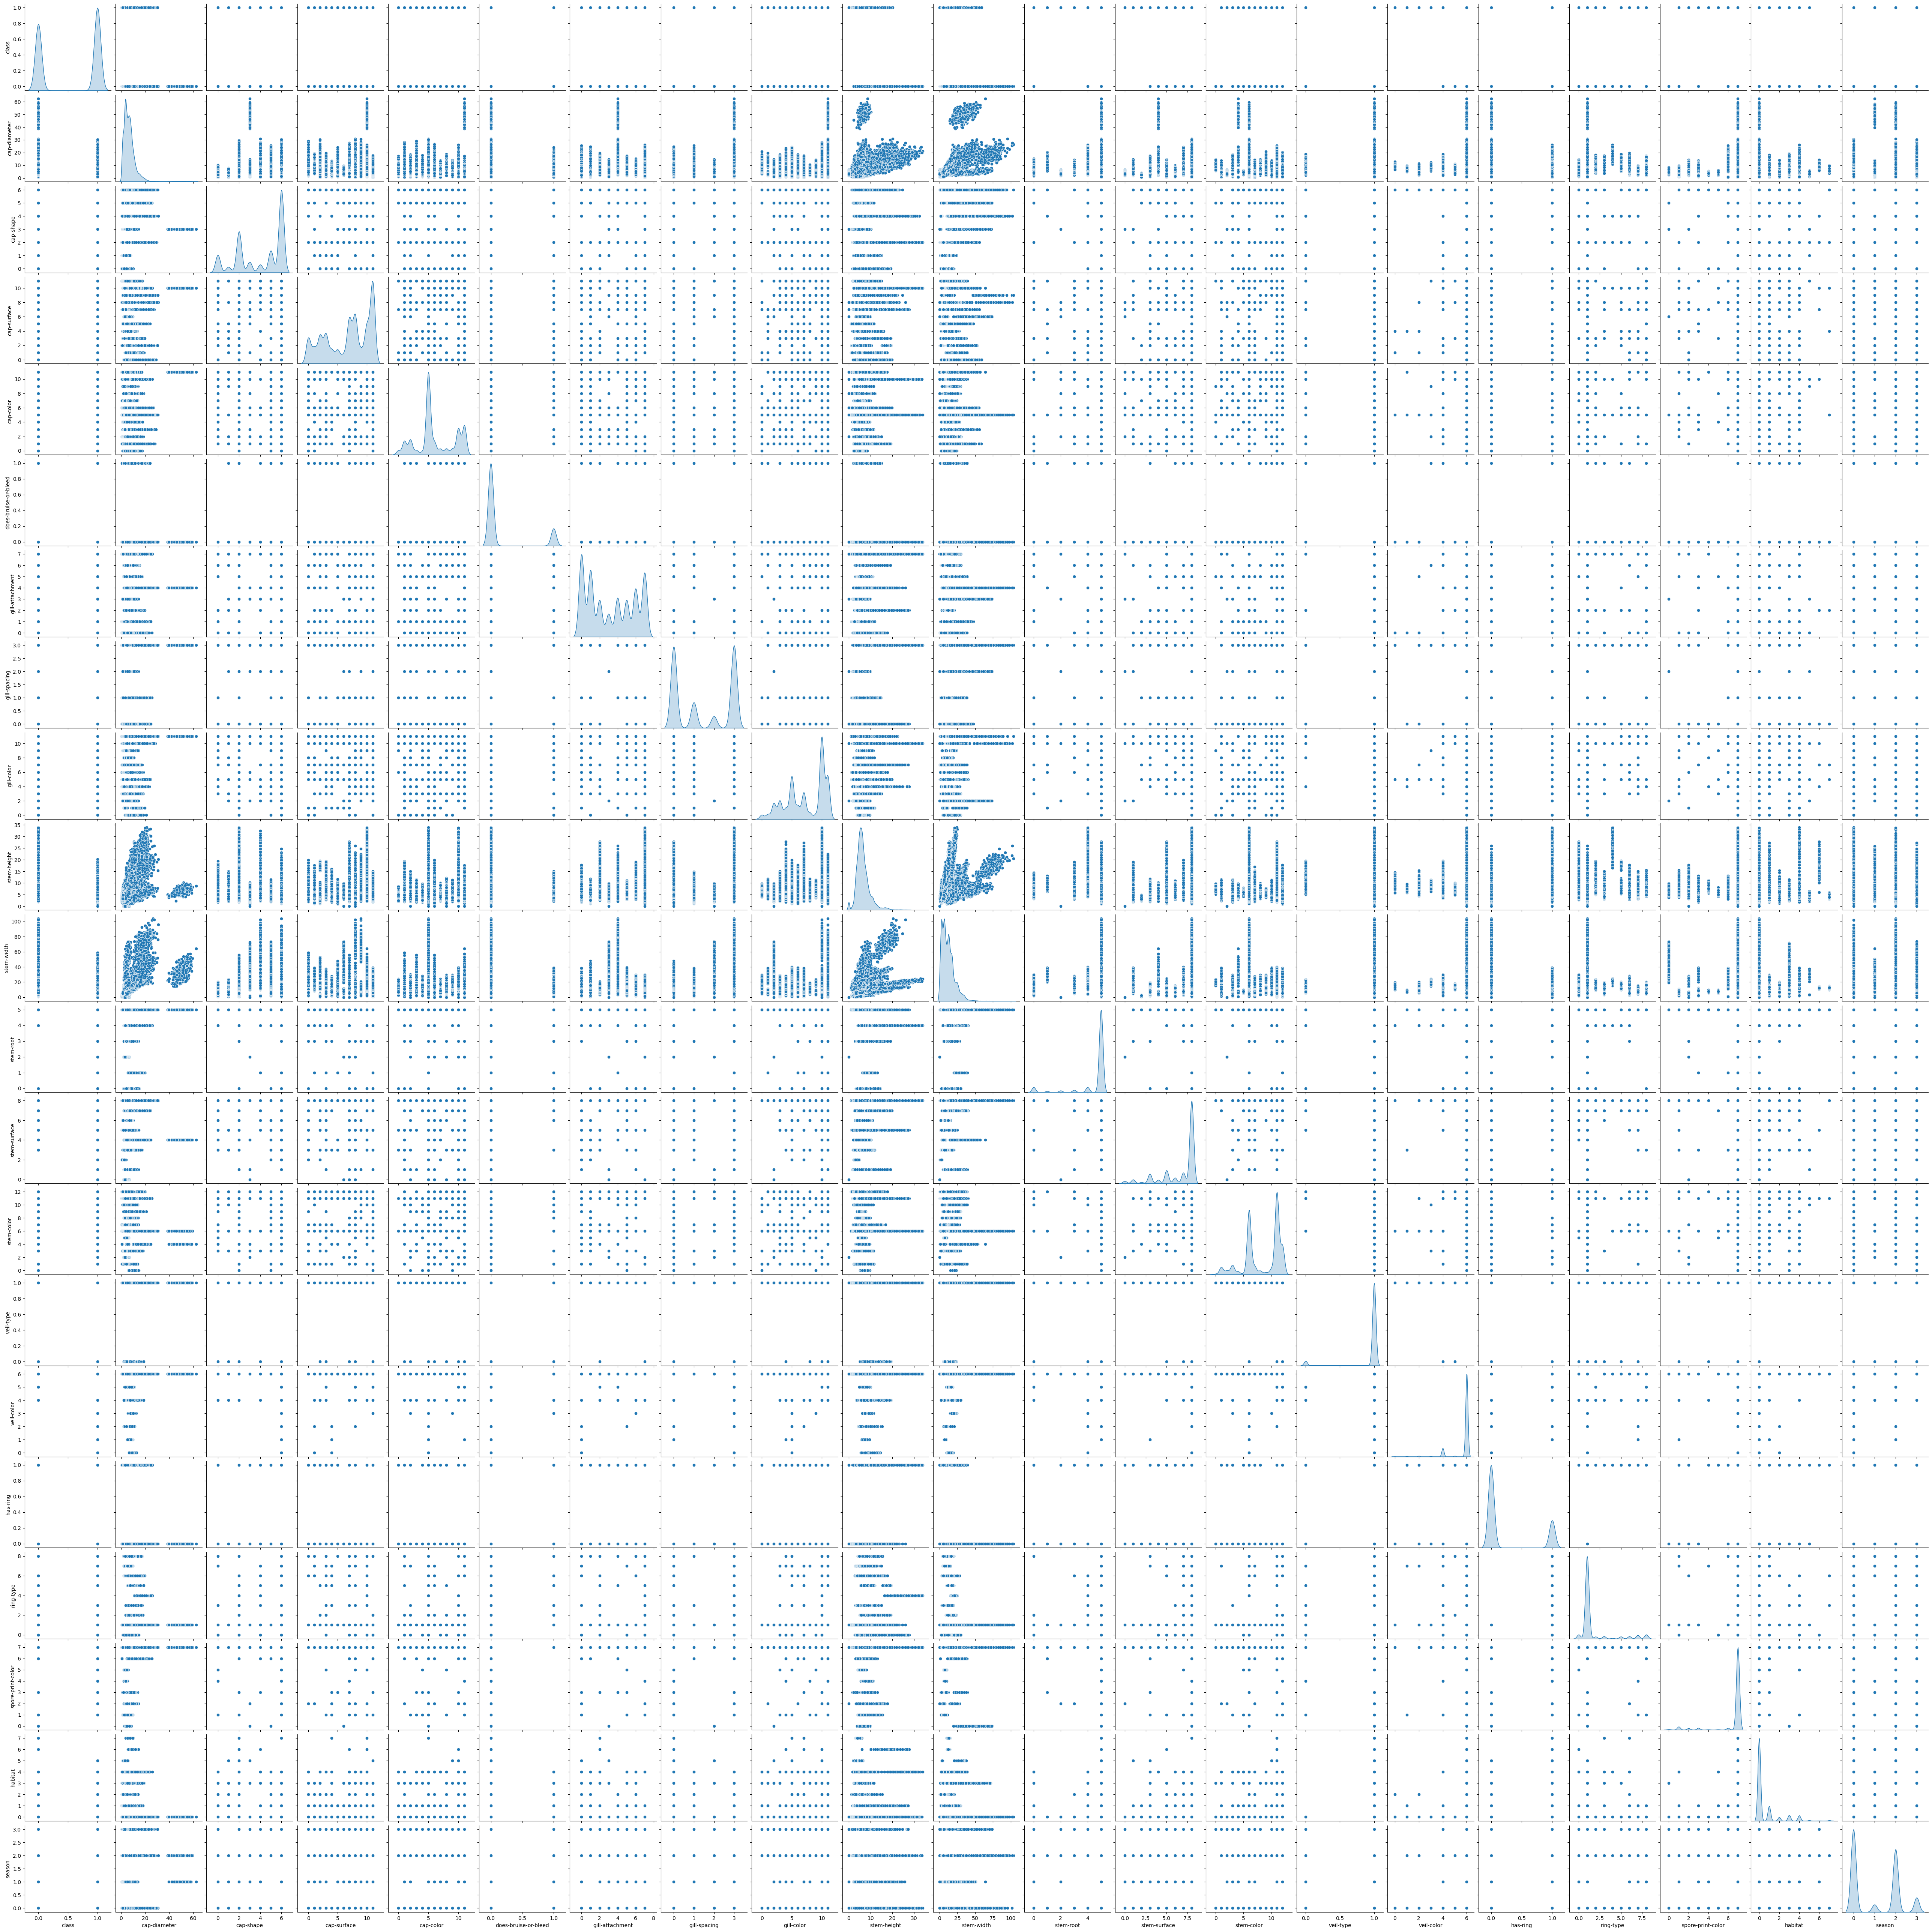

In [9]:
# Scatter plot matrix for all features
data = df.copy()
label_encoder = LabelEncoder()
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = label_encoder.fit_transform(data[col])
plt.figure(figsize=(15, 12))
sns.pairplot(data, diag_kind='kde')
plt.show()

## **3. Data Cleaning and Preprocessing**

#### **After turning categorical features into numeric features, the class labels are as such:**
+ Before: p (poisonous) -> After: 1
+ Before: e (edible) -> After: 0

In [16]:
# Convert non-numeric values to numeric values
transformed_df = df.copy()
label_encoder = LabelEncoder()
for col in transformed_df.columns:
    if transformed_df[col].dtype == 'object':
        transformed_df[col] = label_encoder.fit_transform(transformed_df[col])

print("Column types before and after encoding:")
print("Column\t\t      Before   After")
rows = []
for col in transformed_df.columns:
    rows.append([col, df[col].dtype, transformed_df[col].dtype])
print(pd.DataFrame(rows).to_string(index=False, header=False))

# Address missing values
for col in transformed_df.columns:
    if df[col].dtype == 'object':
        transformed_df[col].fillna(transformed_df[col].mode()[0], inplace=True)
    else:
        transformed_df[col].fillna(transformed_df[col].mean(), inplace=True)

print("\nNumber of missing values before imputation:") # Check which columns have missing values
print(df.isnull().sum())

# Check if missing values are addressed
print("\nNumber of missing values after imputation:")
print(transformed_df.isnull().sum())

# Z-score method to detect and remove outliers
z_scores = np.abs(stats.zscore(transformed_df.select_dtypes(include='number')))
threshold = 3
outliers = np.where(z_scores > threshold)
df_no_outliers = transformed_df[(z_scores < threshold).all(axis=1)]

# Check the shape of the dataframe before and after removing outliers
print("\nShape of the dataframe before removing outliers:", transformed_df.shape)
print("Shape of the dataframe after removing outliers:", df_no_outliers.shape)

# Check for and remove duplicate rows
duplicate_rows = df_no_outliers.duplicated()
df_no_duplicates = df_no_outliers[~duplicate_rows]

# Check the shape of the dataframe before and after removing duplicates
print("\nShape of the dataframe before removing duplicates:", df_no_outliers.shape)
print("Shape of the dataframe after removing duplicates:", df_no_duplicates.shape)

Column types before and after encoding:
Column		      Before   After
               class  object   int32
        cap-diameter float64 float64
           cap-shape  object   int32
         cap-surface  object   int32
           cap-color  object   int32
does-bruise-or-bleed  object   int32
     gill-attachment  object   int32
        gill-spacing  object   int32
          gill-color  object   int32
         stem-height float64 float64
          stem-width float64 float64
           stem-root  object   int32
        stem-surface  object   int32
          stem-color  object   int32
           veil-type  object   int32
          veil-color  object   int32
            has-ring  object   int32
           ring-type  object   int32
   spore-print-color  object   int32
             habitat  object   int32
              season  object   int32

Number of missing values before imputation:
class                       0
cap-diameter                0
cap-shape                   0
cap-surface        

In [17]:
# New reference for cleaned data
cleaned_df = df_no_duplicates.copy()

# Normalize the dataset
scaler = preprocessing.MinMaxScaler()
data = scaler.fit_transform(cleaned_df)
scaled_df = pd.DataFrame(data, columns=cleaned_df.columns)

# Summary statistics
print("Summary statistics of cleaned dataset before normalization:")
print(cleaned_df.describe())

print("\nSummary statistics of cleaned dataset after normalization:")
print(scaled_df.describe())

Summary statistics of cleaned dataset before normalization:
              class  cap-diameter     cap-shape   cap-surface     cap-color  \
count  46093.000000  46093.000000  46093.000000  46093.000000  46093.000000   
mean       0.541405      6.095994      4.054737      6.670384      6.219795   
std        0.498288      3.841055      2.134447      3.749399      3.185057   
min        0.000000      0.380000      0.000000      0.000000      0.000000   
25%        0.000000      3.240000      2.000000      3.000000      5.000000   
50%        1.000000      5.500000      5.000000      8.000000      5.000000   
75%        1.000000      8.150000      6.000000     10.000000     10.000000   
max        1.000000     22.500000      6.000000     11.000000     11.000000   

       does-bruise-or-bleed  gill-attachment  gill-spacing    gill-color  \
count          46093.000000     46093.000000  46093.000000  46093.000000   
mean               0.206669         3.084698      1.424490      7.239125   


In [19]:
# Select the best 10 features
best_df = scaled_df.copy()
select_bestk_cols = SelectKBest(mutual_info_classif, k=10)
select_bestk_cols.fit(best_df[best_df.columns[1:]], best_df[best_df.columns[0]])
print("Columns to be kept:\n",best_df.columns[1:][select_bestk_cols.get_support()])
print("\nColumns to be removed:\n",best_df.columns[1:][~select_bestk_cols.get_support()])
best_df = best_df.drop(best_df.columns[1:][~select_bestk_cols.get_support()],axis=1)

# The structure of the dataset after feature selection
print("\nDataset dimensions (rows, columns):", best_df.shape)
print("\nFirst few rows of the dataset:")
print(best_df.head())
print("Summary statistics of the dataset:")
print(best_df.describe())

Columns to be kept:
 Index(['cap-diameter', 'cap-surface', 'cap-color', 'gill-attachment',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'ring-type'],
      dtype='object')

Columns to be removed:
 Index(['cap-shape', 'does-bruise-or-bleed', 'gill-spacing', 'gill-color',
       'veil-type', 'veil-color', 'has-ring', 'spore-print-color', 'habitat',
       'season'],
      dtype='object')

Dataset dimensions (rows, columns): (46093, 11)

First few rows of the dataset:
   class  cap-diameter  cap-surface  cap-color  gill-attachment  stem-height  \
0    0.0      0.568264     0.909091   0.909091         1.000000     0.983461   
1    1.0      0.147830     0.909091   0.909091         0.285714     0.272265   
2    1.0      0.192586     0.909091   0.636364         0.285714     0.243003   
3    1.0      0.173146     0.909091   0.636364         0.285714     0.246183   
4    1.0      0.108499     0.909091   0.636364         0.285714     0.213740   

   stem-

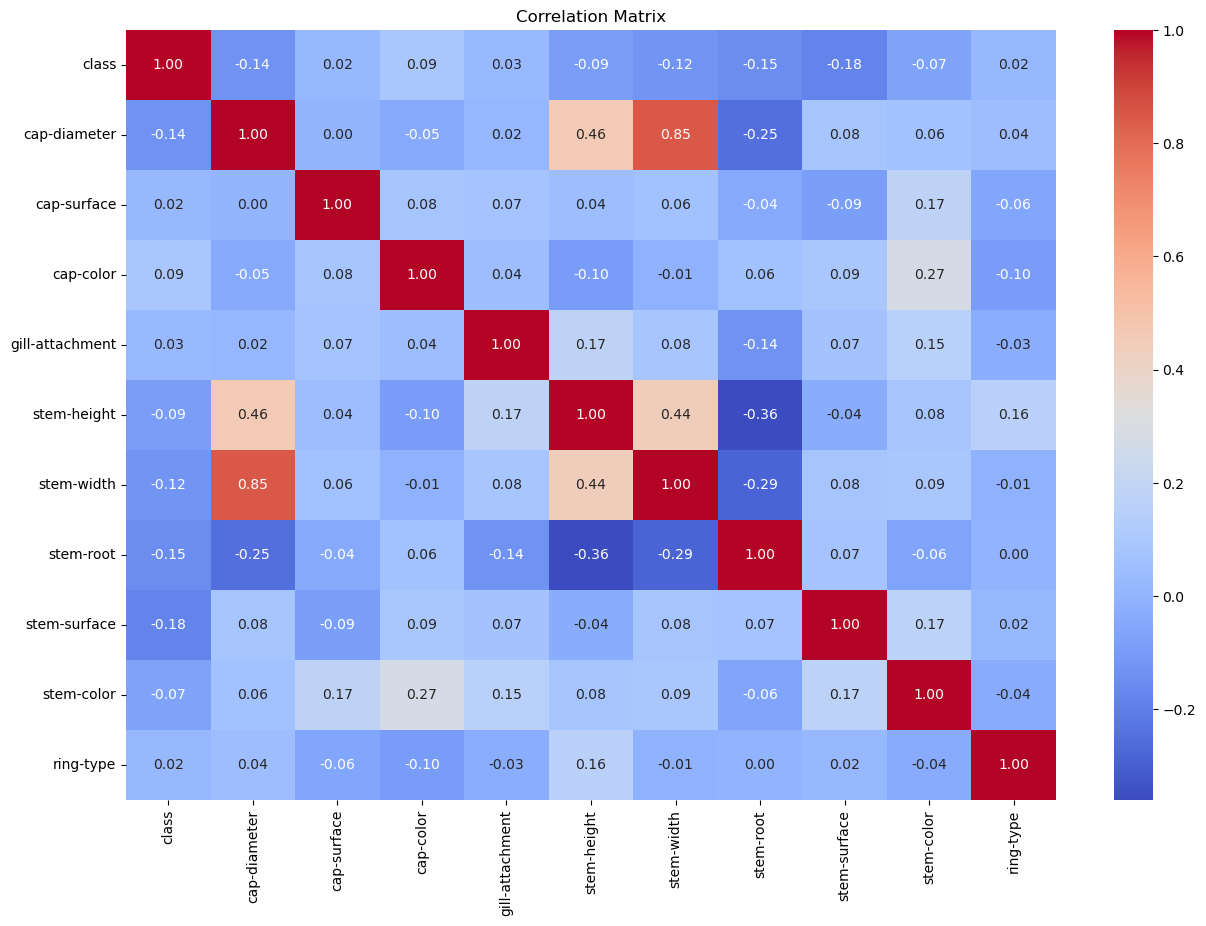

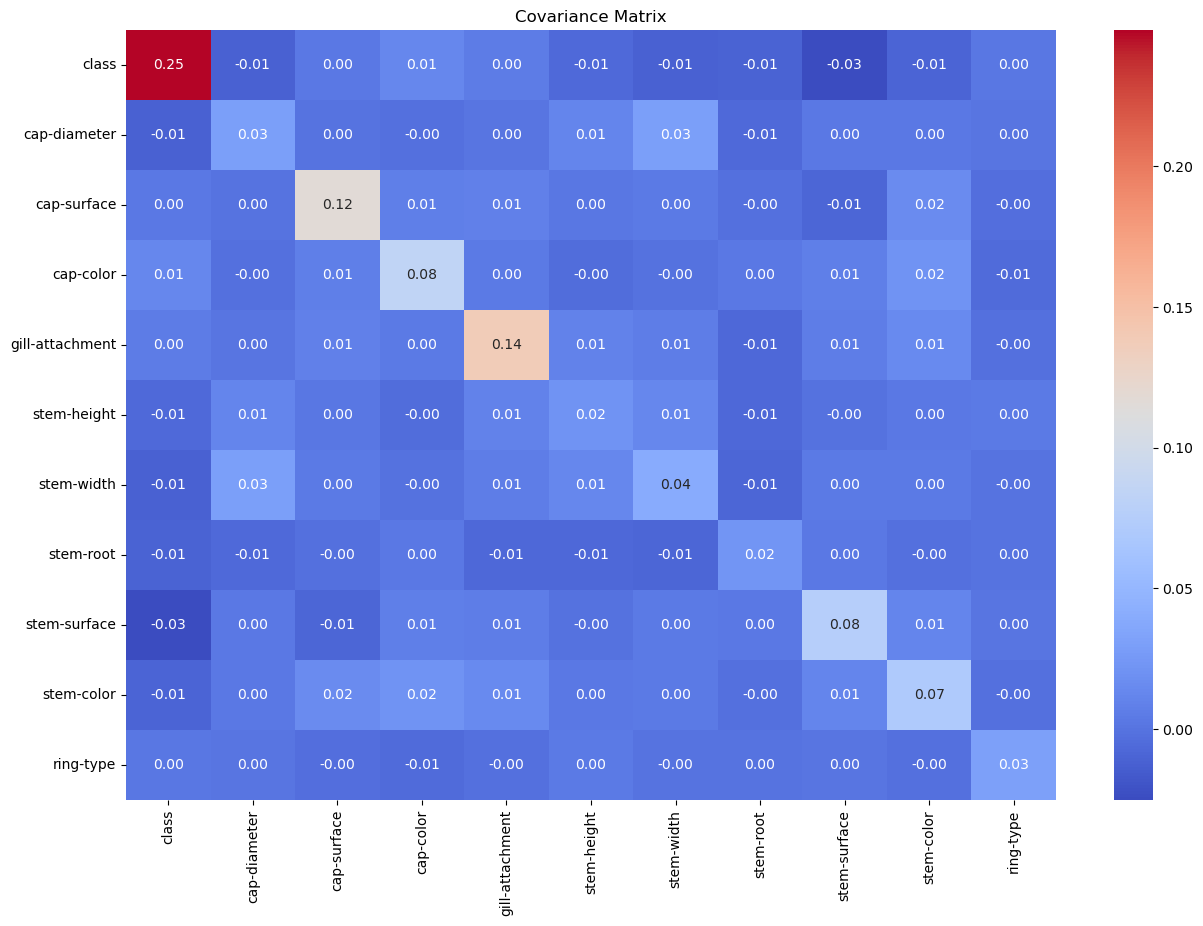

In [20]:
# Correlation analysis
correlation_matrix = best_df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Covariance analysis
covariance_matrix = best_df.cov()
plt.figure(figsize=(15, 10))
sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Covariance Matrix')
plt.show()

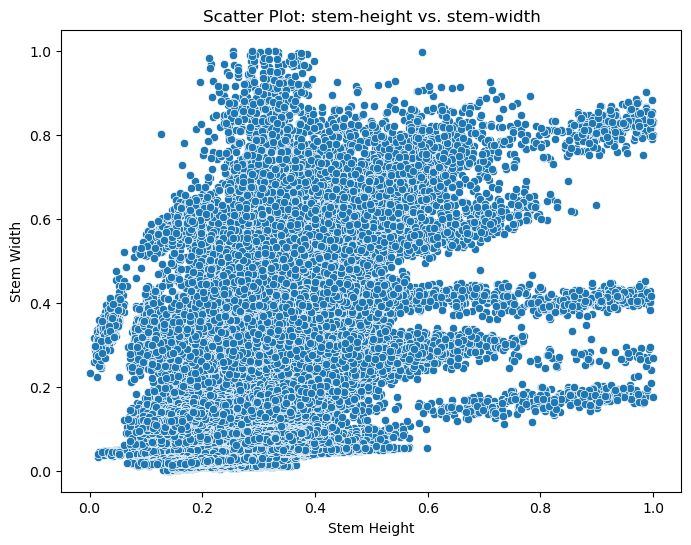

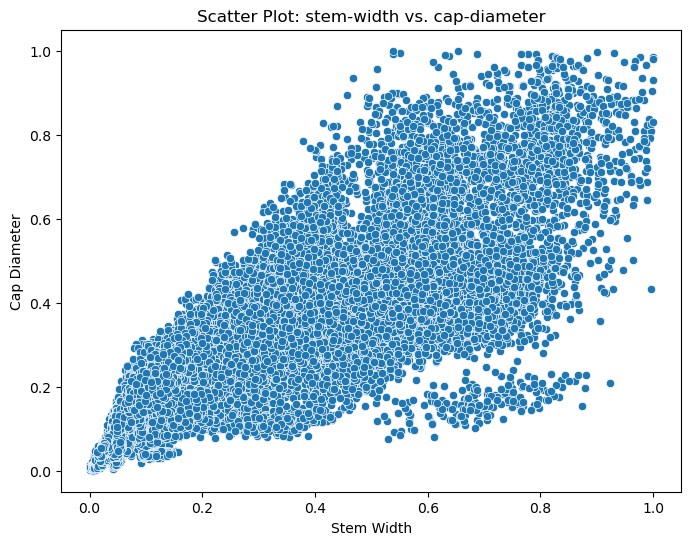

<Figure size 1500x1200 with 0 Axes>

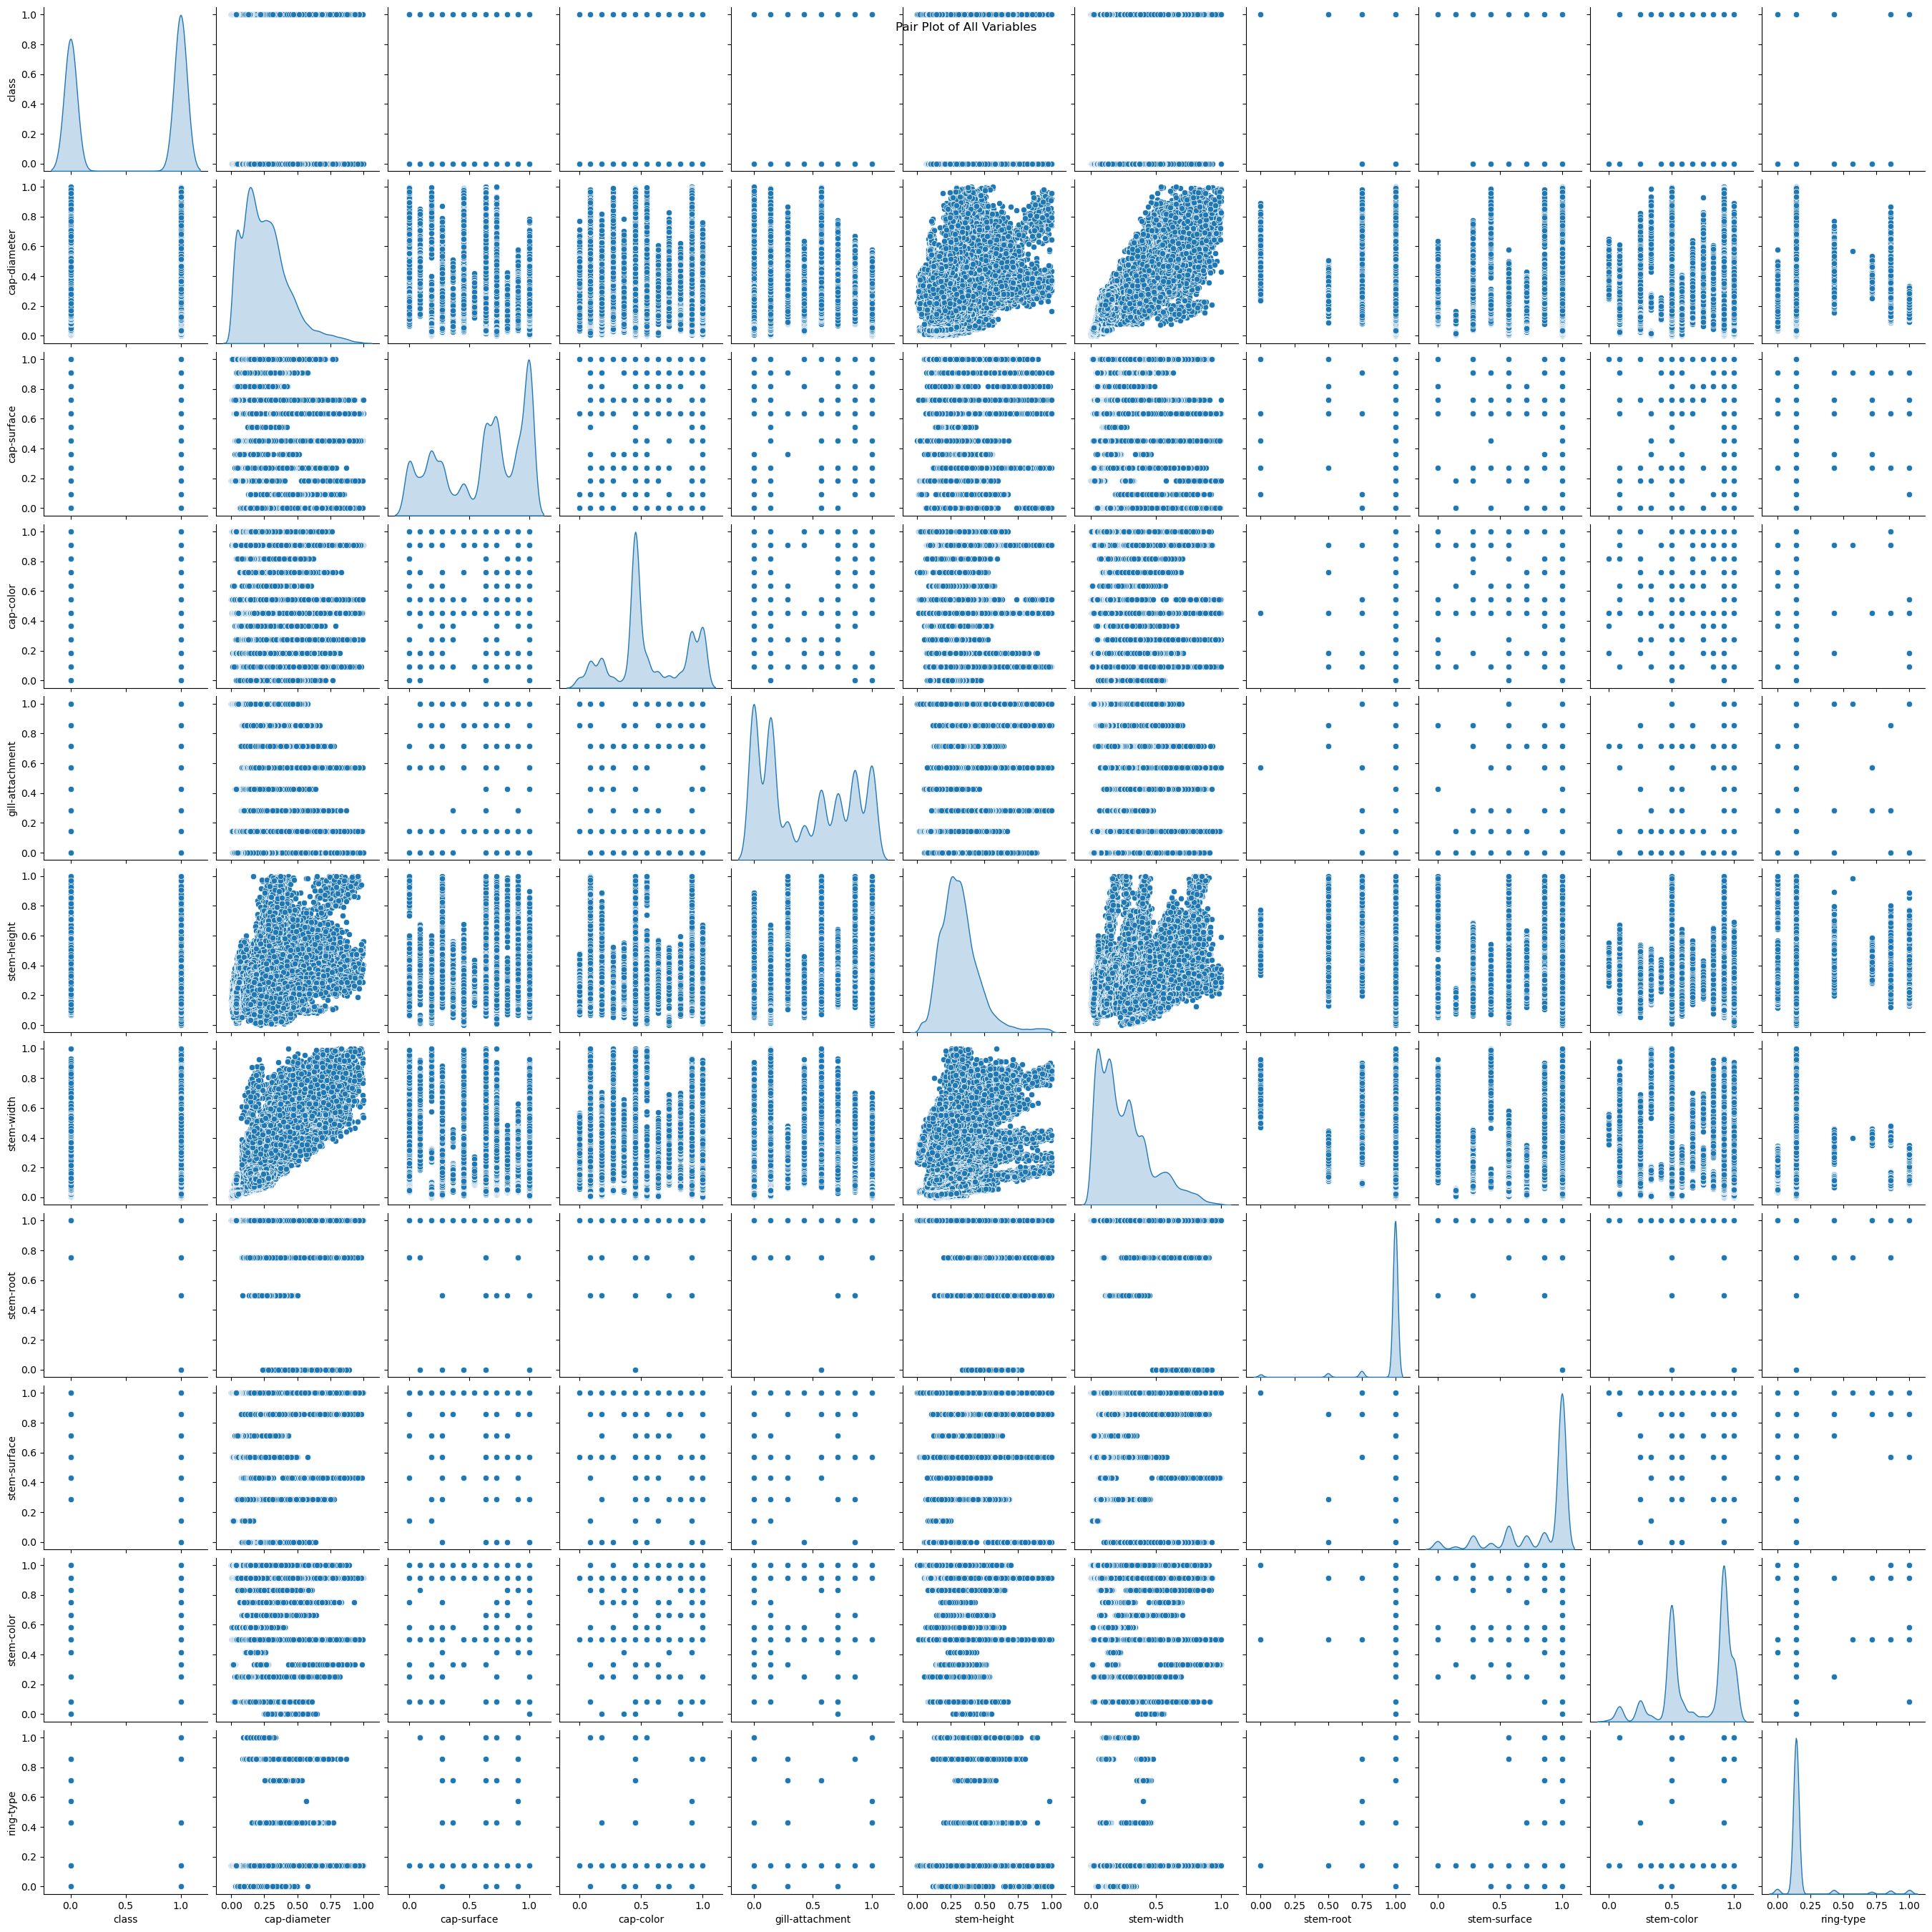

In [21]:
# Scatter plot for variables with high correlation
plt.figure(figsize=(8, 6))
sns.scatterplot(x='stem-height', y='stem-width', data=best_df)
plt.title('Scatter Plot: stem-height vs. stem-width')
plt.xlabel('Stem Height')
plt.ylabel('Stem Width')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='stem-width', y='cap-diameter', data=best_df)
plt.title('Scatter Plot: stem-width vs. cap-diameter')
plt.xlabel('Stem Width')
plt.ylabel('Cap Diameter')
plt.show()

# Pair plot of all variables
plt.figure(figsize=(15, 12))
sns.pairplot(best_df, diag_kind='kde')
plt.suptitle('Pair Plot of All Variables')
plt.show()

In [22]:
# Split the dataset
X = best_df.drop(columns=['class'])  # Features
y = best_df['class']  # Target variable

# Perform stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Print the shapes of sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (36874, 10)
Shape of X_test: (9219, 10)
Shape of y_train: (36874,)
Shape of y_test: (9219,)


## **4. Model Selection and Training**

### **4.1. Naïve Bayes**
##### **with 5.1. Model Evaluation**
##### **and 6.1. Model Optimization**

Naïve Bayes Accuracy: 0.5743573055645949

Classification Report:
              precision    recall  f1-score   support

         0.0       0.52      0.87      0.65      4228
         1.0       0.74      0.33      0.45      4991

    accuracy                           0.57      9219
   macro avg       0.63      0.60      0.55      9219
weighted avg       0.64      0.57      0.54      9219

Scores:  [0.60321076 0.53487363 0.53519905 0.55022782 0.67747885]
0.58 accuracy with a standard deviation of 0.05


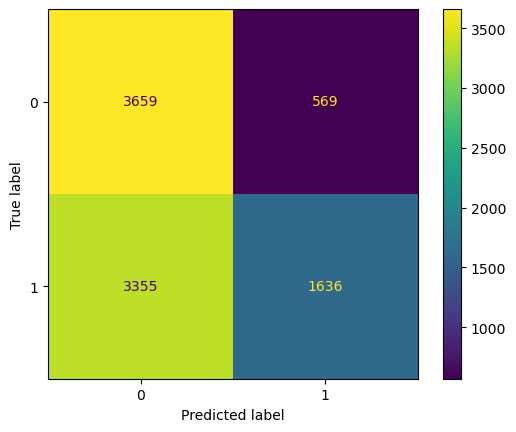

In [23]:
# Instantiate the Gaussian Naïve Bayes model
nb_model = GaussianNB()

# Fit the model to the training data
nb_X_train, nb_y_train = X_train, y_train
nb_X_test, nb_y_test = X_test, y_test
nb_model.fit(nb_X_train, nb_y_train)

# Predictions on the test data
nb_y_pred = nb_model.predict(nb_X_test)

# Evaluate the model
nb_acc = accuracy_score(nb_y_test, nb_y_pred)
print("Naïve Bayes Accuracy:", nb_acc)

# Classification report
print("\nClassification Report:")
print(classification_report(nb_y_test, nb_y_pred))

# Confusion matrix
nb_cm = confusion_matrix(nb_y_test, nb_y_pred)
nb_disp = ConfusionMatrixDisplay(confusion_matrix=nb_cm)
nb_disp.plot()

# Cross validation / optimization
nb_scores = cross_val_score(nb_model, X, y, cv=5)
print("Scores: ", nb_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (nb_scores.mean(), nb_scores.std()))

Reason for chooesing: 
Naïve Bayes is a good model for classification tasks, especially when dealing with categorical features, 
due to its simplicity, and ability to handle high-dimensional data. 
In this mushroom dataset, which contains categorical features related to various attributes of mushrooms, 
Naïve Bayes can effectively learn the probability of a mushroom belonging to a particular class (poisonous or edible) 
based on the observed values of its features. 
Additionally, Naïve Bayes is less prone to overfitting compared to more complex models, 
making it suitable for datasets with limited samples or noisy features. 


### **4.2. Random Forest**
##### **with 5.2. Model Evaluation**
##### **and 6.2. Model Optimization**

Best hyperparameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Best model:  RandomForestClassifier(random_state=42)

Accuracy:  0.9994576418266623

Random Forest Tree 0 Training Accuracy: 1.0
Random Forest Tree 0 Testing Accuracy: 0.9991322269226597

Random Forest Tree 1 Training Accuracy: 0.9998450273139359
Random Forest Tree 1 Testing Accuracy: 0.9986983403839896

Random Forest Tree 2 Training Accuracy: 0.999961256828484
Random Forest Tree 2 Testing Accuracy: 0.9984813971146546

Random Forest Tree 3 Training Accuracy: 0.9998062841424199
Random Forest Tree 3 Testing Accuracy: 0.9981559822106519

Random Forest Tree 4 Training Accuracy: 1.0
Random Forest Tree 4 Testing Accuracy: 0.9984813971146546

Random Forest Tree 5 Training Accuracy: 0.999961256828484
Random Forest Tree 5 Testing Accuracy: 0.9984813971146546

Random Forest Tree 6 Training Accuracy: 0.9999225136569679
Random Forest Tree 6 Testing Accuracy: 0.9989152836533246

Random Fo

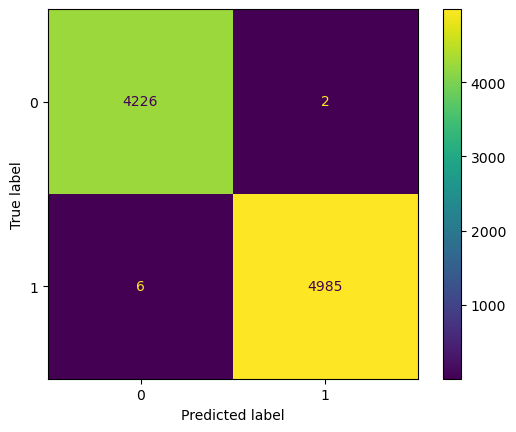

In [27]:
# Training and testing data
rf_X_train, rf_y_train = X_train, y_train
rf_X_test, rf_y_test = X_test, y_test

# Set random forest parameters
rf_n_trees = 100
rf_n_train = rf_X_train.shape[0]
rf_n_sample = int(0.7 * rf_n_train)
rf_n_test = rf_X_test.shape[0]

#Define parameter grid
param_grid = {
    'n_estimators': [50, 75, 100],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up and perform the grid search
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5)
grid_search.fit(rf_X_train, rf_y_train)

# Display best hyperparameters, model, and accuracy
print("Best hyperparameters: ", grid_search.best_params_)
print("\nBest model: ", grid_search.best_estimator_)
print("\nAccuracy: ", grid_search.best_estimator_.score(rf_X_test, rf_y_test))

# Implement random forest classifier
allTrees = [clone(RandomForestClassifier(n_estimators=10, random_state=42)) for _ in range(rf_n_trees)]


# Train and test random forest
for i in range(rf_n_trees):
    x = sample_without_replacement(rf_n_train, rf_n_sample)
    allTrees[i].fit(rf_X_train.iloc[x,:], rf_y_train.iloc[x]) 
    print("\nRandom Forest Tree", i, "Training Accuracy:", allTrees[i].score(rf_X_train.iloc[x,:], rf_y_train.iloc[x]))
    print("Random Forest Tree", i, "Testing Accuracy:", allTrees[i].score(rf_X_test, rf_y_test))

all_results = np.empty([rf_n_test, rf_n_trees], dtype=int)

# Predict classes
for i in range(rf_n_trees):
    y_pred_tree_i = allTrees[i].predict(rf_X_test)
    all_results[:,i] = y_pred_tree_i

y_pred_majority_votes, _ = mode(all_results, axis=1)

# Evaluate the model
rf_acc = metrics.accuracy_score(rf_y_test, y_pred_majority_votes.reshape([-1]))
print("\nRandom Forest Accuracy:", rf_acc)

# Classification report
print("\nClassification Report:")
print(classification_report(rf_y_test, y_pred_majority_votes.reshape([-1])))

# Confusion matrix
rf_cm = confusion_matrix(rf_y_test, y_pred_majority_votes.reshape([-1]))
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm)
rf_disp.plot()

We chose Random Forest as our ensemble method due to its robust performance with minimal tuning and its capacity to handle large datasets with numerous features, such as ours. Random Forest constructs multiple decision trees independently and combines their predictions, resulting in a reliable model. Compared to Gradient Boosting, Random Forest is less prone to overfitting, making it suitable for model interpretability and simplicity. Moreover, given our dataset's complexity and focus on achieving accurate predictions, Random Forest's ability to handle high-dimensional data and provide feature importances based on impurity reduction across trees makes it the preferred choice over Gradient Boosting.

### **4.3. Neural Networks**
##### **with 5.3. Model Evaluation**
##### **and 6.3. Model Optimization**

1153/1153 - 3s - loss: 0.7131 - accuracy: 0.5279 - 3s/epoch - 2ms/step
1153/1153 - 2s - loss: 2.0272 - accuracy: 0.1822 - 2s/epoch - 2ms/step
1153/1153 - 2s - loss: 2.4516 - accuracy: 0.0000e+00 - 2s/epoch - 2ms/step
1153/1153 - 1s - loss: 0.4654 - accuracy: 0.7736 - 1s/epoch - 1ms/step
1153/1153 - 1s - loss: 0.6714 - accuracy: 0.5988 - 1s/epoch - 1ms/step
1153/1153 - 2s - loss: 1.9381 - accuracy: 0.5305 - 2s/epoch - 2ms/step
1153/1153 - 2s - loss: 0.0697 - accuracy: 0.9779 - 2s/epoch - 1ms/step
1153/1153 - 2s - loss: 0.4744 - accuracy: 0.7741 - 2s/epoch - 1ms/step
1153/1153 - 2s - loss: 0.6796 - accuracy: 0.5679 - 2s/epoch - 1ms/step
1153/1153 - 2s - loss: 0.5547 - accuracy: 0.7053 - 2s/epoch - 2ms/step
1153/1153 - 2s - loss: 0.7183 - accuracy: 0.5414 - 2s/epoch - 1ms/step
1153/1153 - 2s - loss: 2.1761 - accuracy: 0.1107 - 2s/epoch - 1ms/step
1153/1153 - 2s - loss: 0.2186 - accuracy: 0.9129 - 2s/epoch - 2ms/step
1153/1153 - 2s - loss: 0.5462 - accuracy: 0.7031 - 2s/epoch - 1ms/step
11

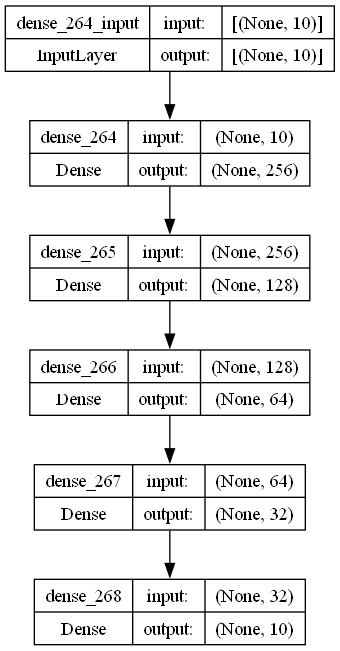

In [28]:
# Training and testing data
nn_X_train, nn_y_train = X_train, y_train
nn_X_test, nn_y_test = X_test, y_test

# Create hyperparameter sets
epochs = [1, 10, 100]
learning_rate = [0.001, 0.01, 0.1]
batch_size = [460, 4600, 46000]
hidden_layers = [1, 2, 3]

# Define loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Placeholders for best hyperparameters
best_accuracy = 0
best_model = None
best_epochs = epochs[0]
best_learning_rate = learning_rate[0]
best_batch_size = batch_size[0]
best_hidden_layers = hidden_layers[0]

# Loop through hyperparameters and update when accuracy improves
for hl in hidden_layers:
    for lr in learning_rate:
        for epoch in epochs:
            for size in batch_size:
                # Create neural network with 'hl' hidden layers
                model = tf.keras.models.Sequential()
                model.add(tf.keras.layers.Dense(32*(2**hl), input_dim=10, activation='relu'))
                for i in range(hl-1, -1, -1):
                    model.add(tf.keras.layers.Dense(32*(2**i), activation='relu'))
                model.add(tf.keras.layers.Dense(10, activation='softmax'))

                # Train and evaluate the model
                optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
                model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
                model.fit(nn_X_train, nn_y_train, epochs=epoch, batch_size=size, verbose=0)
                acc = model.evaluate(nn_X_train, nn_y_train, verbose=2)[1]
                if (acc > best_accuracy):
                    best_accuracy = acc
                    best_model = model
                    best_epochs = epoch
                    best_learning_rate = lr
                    best_batch_size = size
                    best_hidden_layers = hl

# Display the best model structure
best_model.summary()
img_file = 'model_1.png'
tf.keras.utils.plot_model(best_model, to_file=img_file, show_shapes=True)

Neural Network Accuracy: 0.9980475105759844

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4228
         1.0       1.00      1.00      1.00      4991

    accuracy                           1.00      9219
   macro avg       1.00      1.00      1.00      9219
weighted avg       1.00      1.00      1.00      9219



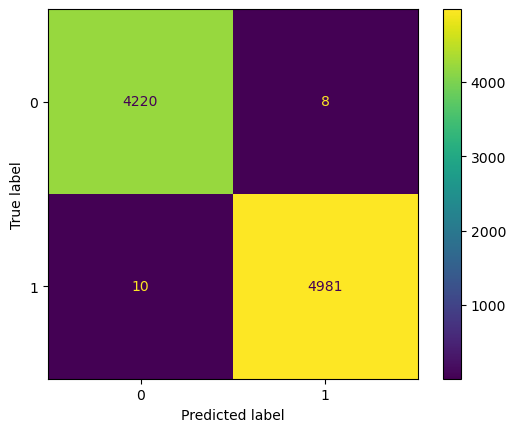

In [30]:
# Evaluate the model
nn_predictions = best_model(nn_X_test.to_numpy())
nn_y_pred = np.argmax(nn_predictions, axis=1)
nn_acc = metrics.accuracy_score(nn_y_test, nn_y_pred)
print("Neural Network Accuracy:", nn_acc)

# Classification report
print("\nClassification Report:")
print(classification_report(nn_y_test, nn_y_pred))

# Confusion matrix
nn_cm = confusion_matrix(nn_y_test, nn_y_pred)
nn_disp = ConfusionMatrixDisplay(confusion_matrix=nn_cm)
nn_disp.plot()

For the deep learning model, we chose to go with a Neural Network, for several reasons other than the fact that it was the only option. Firstly, NN are able to capture the complex relationships between data, and as our set started with over 46,000 records and 20 initial features pre-cleaning, NN seemed like the perfect choice to handle such a large dataset. Moreover, NN are capable of feature selection on their own, which makes the cleaning process easier as the model is capable of making the best decision that a human may overlook. Futhermore, NN boast scalability, flexibility, generalization, as well as superior performance, all of which have incentivized us to use NN as our model of choice for deep learning.

Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_354 (Dense)           (None, 256)               5376      
                                                                 
 dense_355 (Dense)           (None, 128)               32896     
                                                                 
 dense_356 (Dense)           (None, 64)                8256      
                                                                 
 dense_357 (Dense)           (None, 32)                2080      
                                                                 
 dense_358 (Dense)           (None, 10)                330       
                                                                 
Total params: 48938 (191.16 KB)
Trainable params: 48938 (191.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
289/289 - 1s - 

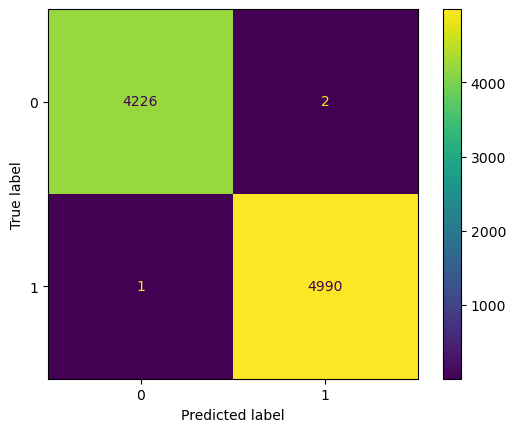

In [38]:
# Split the post-feature-selection dataset
nn2_scaled_df = scaled_df.copy()
nn2_X = nn2_scaled_df.drop(columns=['class'])  # Features
nn2_y = nn2_scaled_df['class']  # Target variable

# Perform stratified sampling
nn2_X_train, nn2_X_test, nn2_y_train, nn2_y_test = train_test_split(nn2_X, nn2_y, test_size=0.2, stratify=nn2_y, random_state=42)

# Create neural network with three hidden layers for the full 20 features
# Number of hidden layers matches that of the best model from the previous section, to save computaion time
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(256, input_dim=20, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

# Display model structure
model2.summary()
img_file2 = 'model_2.png'
tf.keras.utils.plot_model(model2, to_file=img_file2, show_shapes=True)

# Train and evaluate the model using the best hyperparameters
loss_fn2 = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer2 = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
model2.compile(optimizer=optimizer2, loss=loss_fn2, metrics=['accuracy'])
model2.fit(nn2_X_train, nn2_y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0)
nn2_acc_test = model2.evaluate(nn2_X_test, nn2_y_test, verbose=2)[1]
print("Testing Accuracy: ", nn2_acc_test)

# Evaluate the model
nn2_predictions = model2(nn2_X_test.to_numpy())
nn2_y_pred = np.argmax(nn2_predictions, axis=1)
nn2_acc = metrics.accuracy_score(nn2_y_test, nn2_y_pred)
print("Neural Network Accuracy:", nn2_acc)

# Classification report
print("\nClassification Report:")
print(classification_report(nn2_y_test, nn2_y_pred))

# Confusion matrix
nn2_cm = confusion_matrix(nn2_y_test, nn2_y_pred)
nn2_disp = ConfusionMatrixDisplay(confusion_matrix=nn2_cm)
nn2_disp.plot()

### **5. Performance Comparison**

##### Testing Accuracies:
+ Naïve Bayes: 0.5743573055645949
+ Grid Search: 0.9994576418266623
+ Random Forest: 0.9991322269226597
+ Neural Networks (after feature selection): 0.9980475105759844
+ Neural Networks (before feature selection): 0.9996745850959974

As evident from the accuracy values above, the more complicated the model was, the better the testing accuracy was (for the most part). However, this does not necessarily mean that the model is good. This is because a high accuracy can indicate that the model is over-fitted, which means its only really accurate for the data it was tested on, but not necessarily on a different set of data. This is why cross validation and batch testing is important, it helps reduce the effects of over-fitting.

#### Strengths and Weaknesses:

##### **Naïve Bayes**:
**Strengths**:                                              
+ Simple and easy to use/implement
+ Efficient even with high-dimenionality data
+ Can handle categorical attributes
+ Is not affected by missing data to a large degree

**Weaknesses**:
+ Assumes that the features are independent of each other, which is rarely the case
+ Performs poorly with datasets where connections between features is key
+ Rare feature combinations cause 'zero probability' issues

##### **Random Forests**:
**Strengths**:
+ Accurate and robust, can outperform other models
+ Able to handle large high-dimensionality datasets
+ Doesn't neglect feature importance
+ Not as prone to over-fitting as decision trees

**Weaknesses**:
+ Computationally expensive
+ Doesn't perform as well when the dataset is sparse
+ Cannot interpret it compared to decision trees which are easy to understand

##### **Neural Networks**:
**Strengths**:                                              
+ Able to model complex interactions between features
+ Architecturally flexible, can be customized easily
+ Top tier performance
+ Can learn feature hierarchies and perform feature
  selection accordingly

**Weaknesses**:
+ Requires large datasets which aren't always available
+ Computationally expensive
+ Prone to overfitting, so designer must tune it carefully
+ Cannot interpret it to understand the categorization process

### **7. Documentation and Reporting**

Interesting findings and conclusions:
+ Naïve Bayes was the least accurate of all the models
+ Grid search was more accurate in testing as compared to the standard random forest
+ The random forest model boasted a higher accuracy than the neural network that used the pre-feature-selected dataset
+ This could likely be due to overfitting
+ The neural network that was allowed to perform its own feature selection was more accurate than the one that was fed a dataset that has already had its features selected
+ The increase in accuracy between the neural network models is very miniscule, so for future use, the less computationally expensive one (i.e. the first one) could be used with minimal drawbacks
+ The Naïve Bayes model is unsafe to use for classification of this dataset in particular, as it classified 3355/9219 mushrooms as edible (class 0) during testing while they are in fact poisonous (class 1)
+ This could kill people or severly damage their bodies if they were to trust the incorrect classification; therefore, the Naïve Bayes model should not be considered for such use cases